tobac example: Tracking of deep convection based on OLR from convection permitting model simulations with Lat/Lon Tracking
==
This example notebook demonstrates the use of tobac to track deep convection based on the outgoing longwave radiation (OLR) from convection permitting simulations.

This notebook is otherwise identical to the other OLR tracking from model notebook, but using latitude/longitude based tracking.

The simulation results used in this example were performed as part of the ACPC deep convection intercomparison  case study (http://acpcinitiative.org/Docs/ACPC_DCC_Roadmap_171019.pdf) with WRF using the Morrison microphysics scheme. Simulations were performed with a horizontal grid spacing of 4.5 km.

The data used in this example is downloaded from Zenodo automatically as part of the notebooks.

**Import libraries:**

In [1]:
# Import a range of python libraries used in this notebook:
import datetime
import shutil
from pathlib import Path
from six.moves import urllib

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version unknown_dev_version


In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [4]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

**Download example data:**  
The actual download is only necessary once for all example notebooks.


In [5]:
data_out=Path('../')

In [6]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob('data/Example_input_OLR_model.nc'))
if len(data_file) == 0:
    file_path='https://zenodo.org/records/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
    #file_path='http://zenodo..'
    tempfile=Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_path, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_out)
    tempfile.unlink()
    print('data extracted')
    data_file = list(data_out.rglob('data/Example_input_OLR_model.nc'))

In [7]:
#Load Data from downloaded file:
OLR = xr.open_dataset(data_file[0]).OLR

In [8]:
OLR

<xarray.DataArray 'OLR' (time: 96, south_north: 110, west_east: 132)> Size: 6MB
[1393920 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 768B 2013-06-19T19:05:00 ... 2013-06-2...
  * south_north  (south_north) int64 880B 156 157 158 159 ... 262 263 264 265
  * west_east    (west_east) int64 1kB 201 202 203 204 205 ... 329 330 331 332
    latitude     (south_north, west_east) float32 58kB ...
    longitude    (south_north, west_east) float32 58kB ...
    x            (west_east) float64 1kB ...
    y            (south_north) float64 880B ...
    x_0          (west_east) int64 1kB ...
    y_0          (south_north) int64 880B ...
Attributes:
    units:    W m-2

**Data visualisation**

We can take a look at our data both by plotting an individual time step, and by plotting a histogram of the values as shown below:

Visualising the data like this can help make suitable choices for the parameters used in the detection and tracking of features. In this dataset, we can see that the background values range from 275-300 Wm-2, while the coldest features peak around 150 Wm-2

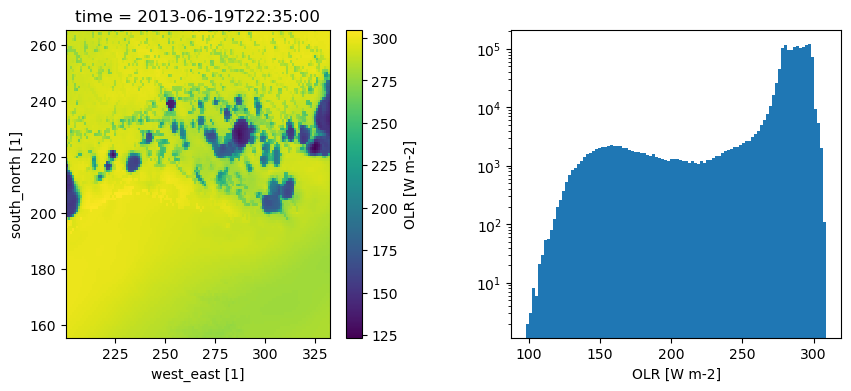

In [9]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
OLR[42].plot(ax=ax1)

ax2 = plt.subplot(1,2,2)
OLR.plot(ax=ax2, bins=100)
plt.yscale("log")

plt.subplots_adjust(wspace=0.35)

**Feature detection:**  
Feature detection is performed based on OLR field and a set of thresholds informed by our data visualisation

In [10]:
# Determine temporal and spatial sampling:
dxy, dt = tobac.get_spacings(OLR)

In [11]:
# Dictionary containing keyword arguments for feature detection step (Keywords could also be given directly in the function call).
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['n_min_threshold']=4
parameters_features['target']='minimum'
parameters_features['threshold']=[250,225,200,175,150]

In [12]:
# Perform feature detection:
print('starting feature detection')
Features = tobac.feature_detection_multithreshold(OLR, dxy, **parameters_features)
Features.to_hdf(savedir / 'Features.h5', 'table')
print('feature detection performed and saved')

starting feature detection
feature detection performed and saved


Feature detection returns a dataframe containing information about each detected object, as shown below:

In [13]:
Features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,south_north,west_east,latitude,longitude,x,y,x_0,y_0
0,0,5,62.743547,59.631834,9,250,1,2013-06-19 19:05:00,2013-06-19 19:05:00,218.743547,260.631834,30.232511,-92.171414,1.175093e+06,9.865960e+05,260.631834,218.743547
1,0,8,67.672946,53.464557,6,250,2,2013-06-19 19:05:00,2013-06-19 19:05:00,223.672946,254.464557,30.441024,-92.459497,1.147341e+06,1.008778e+06,254.464557,223.672946
2,0,11,73.655933,130.435766,5,250,3,2013-06-19 19:05:00,2013-06-19 19:05:00,229.655933,331.435766,30.565232,-88.779386,1.493711e+06,1.035702e+06,331.435766,229.655933
3,0,12,74.385746,122.150648,6,250,4,2013-06-19 19:05:00,2013-06-19 19:05:00,230.385746,323.150648,30.613178,-89.172567,1.456428e+06,1.038986e+06,323.150648,230.385746
4,0,17,64.398814,49.861904,8,225,5,2013-06-19 19:05:00,2013-06-19 19:05:00,220.398814,250.861904,30.309673,-92.634448,1.131129e+06,9.940447e+05,250.861904,220.398814


We can also compare the detected features to the input field to judge whether feature detection has done a good job. Below, we can see that the use of multiple thresholds has allowed the most prominent features (blue) to be detected, as well as less prominent features surrounding them which may represent earlier stages of convective storms

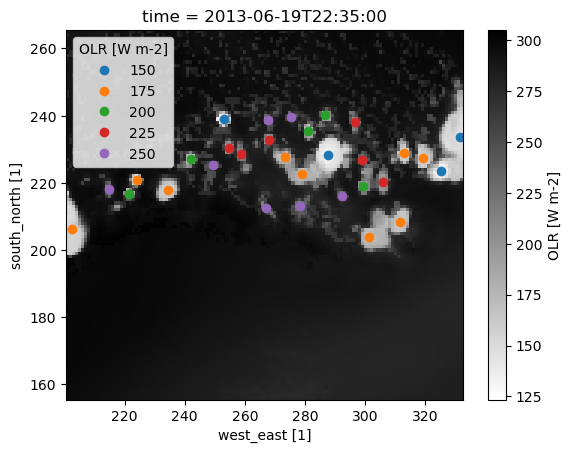

In [14]:
frame=42
OLR[frame].plot(cmap="binary")
points = {
    threshold:plt.plot(ft.west_east, ft.south_north, "o")[0]
    for threshold, ft in Features[Features.frame==frame].groupby("threshold_value")
}
plt.legend(list(points.values()), list(points.keys()), title="OLR [W m-2]")

**Segmentation:**  
The segmentation step is performed to find an area of the input domain that is associated with each detected feature. Segmentation is performed with watershedding based on the detected features and a single threshold value. Unlike feature detection, the watershed operation can distinguish objects which neighbour one another when dividing the domain. Segmentation returns both a mask, with the same dimensions as the input field, showing the region associated with each feature, along with an updated dataframe with information about the segments.

In [15]:
# Dictionary containing keyword options for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=250

In [16]:
# Perform segmentation and save results:
print('Starting segmentation based on OLR.')
Mask_OLR, Features_OLR = tobac.segmentation_2D(Features, OLR, dxy, **parameters_segmentation)
print('segmentation OLR performed, start saving results to files')
Mask_OLR.to_netcdf(savedir / 'Mask_Segmentation_OLR.nc', encoding={"segmentation_mask":{"zlib":True, "complevel":4}})
Features_OLR.to_hdf(savedir / 'Features_OLR.h5', 'table')
print('segmentation OLR performed and saved')

Starting segmentation based on OLR.
segmentation OLR performed, start saving results to files
segmentation OLR performed and saved


The plot below visualises the segmented areas for one time step, showing how each feature detected previously is now associated with a portion of the domain:

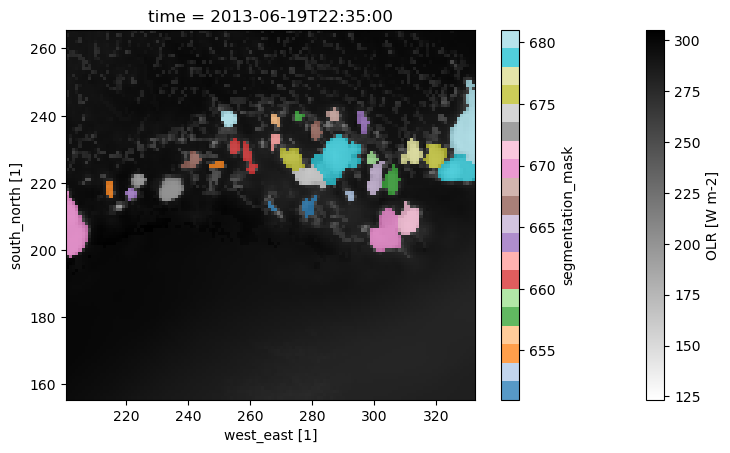

In [17]:
plt.figure(figsize=(8.8, 4.8))
OLR[frame].plot(cmap="binary", cbar_kwargs=dict(pad=0.1))
Mask_OLR[frame].where(Mask_OLR[frame]>0).plot(cmap="tab20", alpha=0.75)

## Trajectory linking with Latitude/Longitude Tracking

Because this is a 2D spatial latitude/longitude based dataset, we can use the very fast `tobac.tracking.linking_trackpy_latlon`, which tracks based on identified latitude/longitude positions.

In [18]:
# Arguments for trajectory linking:
parameters_linking={}
parameters_linking['v_max']=20
parameters_linking['stubs']=2
parameters_linking['order']=1
parameters_linking['extrapolate']=0
parameters_linking['memory']=0
parameters_linking['adaptive_stop_multiplier']=0.5
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=30
parameters_linking['method_linking']='predict'

In [19]:
# Perform linking and save results to file:
Track=tobac.tracking.linking_trackpy_latlon(Features, dt=dt, **parameters_linking)
Track.to_hdf(savedir / 'Track.h5', 'table')

**Visualisation:**

In [20]:
# Set extent of maps created in the following cells:
axis_extent = [-95, -89, 28, 32]        

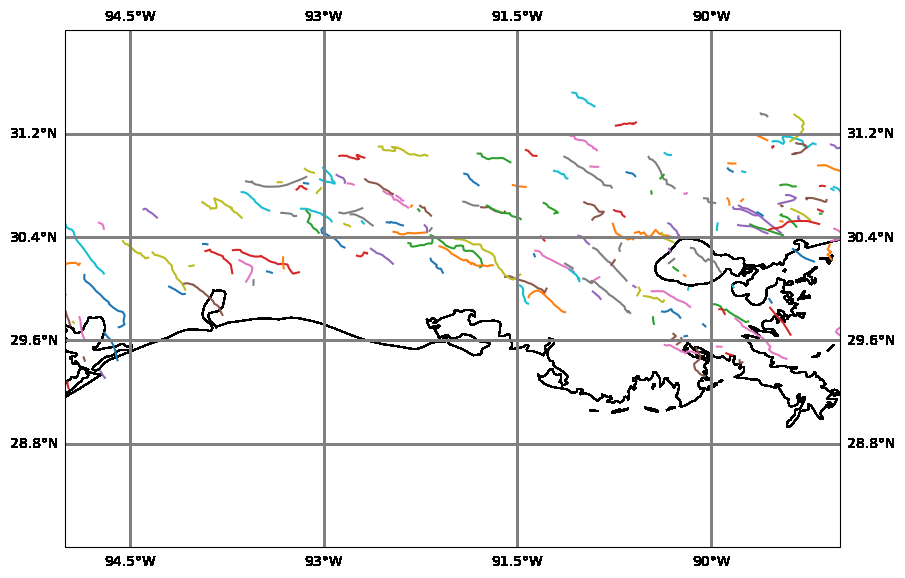

In [21]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map, ax_map = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
ax_map = tobac.map_tracks(Track, axis_extent=axis_extent,  axes=ax_map)

**Analysis**

Text(0, 0.5, 'counts')

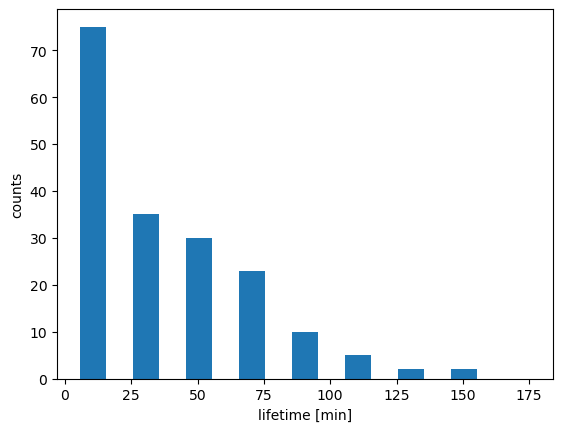

In [22]:
# Lifetimes of tracked clouds:
fig_lifetime, ax_lifetime = plt.subplots()
tobac.plot_lifetime_histogram_bar(Track, axes=ax_lifetime, bin_edges=np.arange(0,200,20), density=False, width_bar=10)
ax_lifetime.set_xlabel('lifetime [min]')
ax_lifetime.set_ylabel('counts')
         

In [23]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.animation_mask_field(
    Track, Features, OLR, Mask_OLR,
    axis_extent=axis_extent,
    vmin=80, vmax=330,
    plot_outline=True, plot_marker=True, marker_track='x',
    plot_number=True, plot_features=True
)

In [24]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

<Figure size 640x480 with 0 Axes>